In [1]:
# Step 1: Environment setup

In [2]:
!pip install -q tensorflow keras torch scikit-learn pandas matplotlib

import os, json, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: reduce TF logging noise
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Create folders for saving artifacts
os.makedirs("models", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("figures", exist_ok=True)

TensorFlow: 2.20.0


In [3]:
import os
import matplotlib.pyplot as plt

def plot_history(histories, title="Training curves", filename="training_curves.png"):
    """
    histories: dict of name -> Keras History
    Plots train/val loss for each history
    """
    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history.get("loss", []), label=f"{name} - train loss")
        plt.plot(h.history.get("val_loss", []), label=f"{name} - val loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()

    os.makedirs("figures", exist_ok=True)
    path = os.path.join("figures", filename)
    plt.savefig(path, dpi=200)
    plt.show()

def plot_accuracy(histories, title="Accuracy curves", filename="accuracy_curves.png"):
    """
    histories: dict of name -> Keras History
    Plots train/val accuracy for each history
    """
    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history.get("accuracy", []), label=f"{name} - train acc")
        plt.plot(h.history.get("val_accuracy", []), label=f"{name} - val acc")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()

    os.makedirs("figures", exist_ok=True)
    path = os.path.join("figures", filename)
    plt.savefig(path, dpi=200)
    plt.show()


In [4]:
# Step 2: Load and prepare the dataset

In [5]:
VOCAB_SIZE = 10000        # num_words in imdb.load_data
MAXLEN = 200              # sequence length (you will vary this later)

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

X_train = pad_sequences(X_train, maxlen=MAXLEN)
X_test  = pad_sequences(X_test,  maxlen=MAXLEN)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train labels distribution:", np.bincount(y_train))
print("Test labels distribution:", np.bincount(y_test))

Train shape: (25000, 200) Test shape: (25000, 200)
Train labels distribution: [12500 12500]
Test labels distribution: [12500 12500]


In [6]:
def build_rnn_model(vocab_size, maxlen, embedding_dim=64, rnn_units=64, learning_rate=1e-3, clipnorm=None):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim)
,
        SimpleRNN(rnn_units),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_lstm_model(vocab_size, maxlen, embedding_dim=64, lstm_units=64, learning_rate=1e-3, clipnorm=None):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim)
,
        LSTM(lstm_units),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=5, batch_size=64, log_name="run.csv"):
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True),
        CSVLogger(os.path.join("logs", log_name))
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

def evaluate_model(model, X_test, y_test):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    perplexity = float(np.exp(loss))  # common proxy when loss is cross-entropy
    return {"loss": float(loss), "accuracy": float(acc), "perplexity": perplexity}

def classification_details(model, X_test, y_test):
    probs = model.predict(X_test, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    report = classification_report(y_test, preds, digits=4)
    cm = confusion_matrix(y_test, preds)
    return report, cm

def plot_history(histories, title="Training curves", filename="training_curves.png"):
    # histories: dict name -> history
    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history["loss"], label=f"{name} - train loss")
        plt.plot(h.history["val_loss"], label=f"{name} - val loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    path = os.path.join("figures", filename)
    plt.savefig(path, dpi=200)
    plt.show()

def plot_accuracy(histories, title="Accuracy curves", filename="accuracy_curves.png"):
    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history["accuracy"], label=f"{name} - train acc")
        plt.plot(h.history["val_accuracy"], label=f"{name} - val acc")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    path = os.path.join("figures", filename)
    plt.savefig(path, dpi=200)
    plt.show()

In [7]:
# Baseline RNN training

In [8]:
rnn_baseline = build_rnn_model(
    vocab_size=VOCAB_SIZE,
    maxlen=MAXLEN,
    embedding_dim=64,
    rnn_units=64,
    learning_rate=1e-3,
    clipnorm=None
)

rnn_baseline.summary()

rnn_hist = train_model(
    rnn_baseline,
    X_train, y_train,
    X_test, y_test,
    epochs=5,
    batch_size=64,
    log_name="rnn_baseline.csv"
)

rnn_baseline.save(os.path.join("models", "rnn_baseline.keras"))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.6552 - loss: 0.6062 - val_accuracy: 0.7908 - val_loss: 0.4593
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.7938 - loss: 0.4466 - val_accuracy: 0.7453 - val_loss: 0.5164


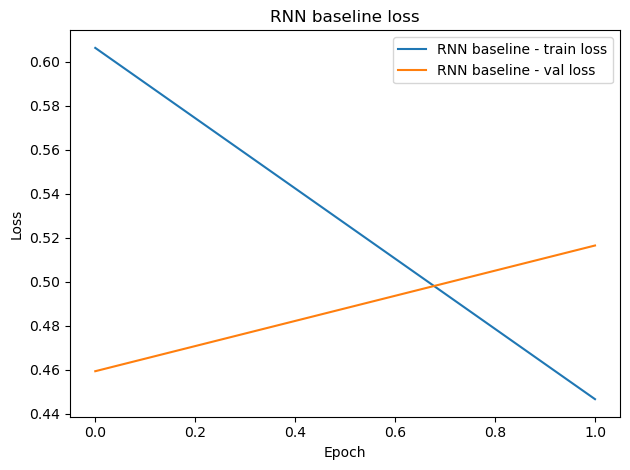

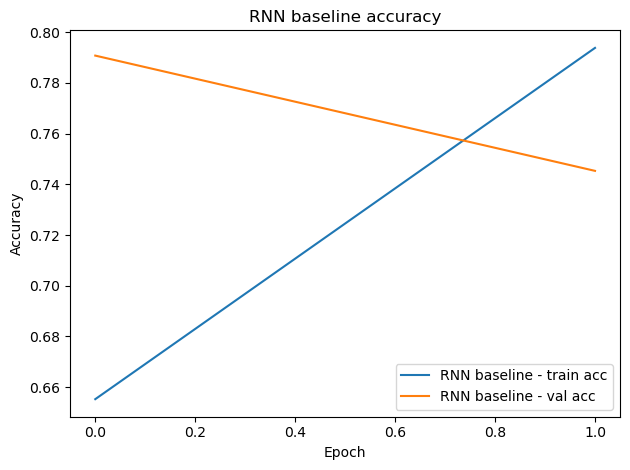

RNN baseline metrics: {'loss': 0.4593239426612854, 'accuracy': 0.7907999753952026, 'perplexity': 1.5830034220735945}

RNN Classification Report:
               precision    recall  f1-score   support

           0     0.7666    0.8362    0.7999     12500
           1     0.8198    0.7454    0.7809     12500

    accuracy                         0.7908     25000
   macro avg     0.7932    0.7908    0.7904     25000
weighted avg     0.7932    0.7908    0.7904     25000

RNN Confusion Matrix:
 [[10452  2048]
 [ 3182  9318]]


In [9]:
plot_history({"RNN baseline": rnn_hist}, title="RNN baseline loss", filename="rnn_baseline_loss.png")
plot_accuracy({"RNN baseline": rnn_hist}, title="RNN baseline accuracy", filename="rnn_baseline_acc.png")

rnn_base_metrics = evaluate_model(rnn_baseline, X_test, y_test)
print("RNN baseline metrics:", rnn_base_metrics)

rnn_report, rnn_cm = classification_details(rnn_baseline, X_test, y_test)
print("\nRNN Classification Report:\n", rnn_report)
print("RNN Confusion Matrix:\n", rnn_cm)

In [10]:
lstm_baseline = build_lstm_model(
    vocab_size=VOCAB_SIZE,
    maxlen=MAXLEN,
    embedding_dim=64,
    lstm_units=64,
    learning_rate=1e-3,
    clipnorm=None
)

lstm_baseline.summary()

lstm_hist = train_model(
    lstm_baseline,
    X_train, y_train,
    X_test, y_test,
    epochs=5,
    batch_size=64,
    log_name="lstm_baseline.csv"
)

lstm_baseline.save(os.path.join("models", "lstm_baseline.keras"))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.7800 - loss: 0.4527 - val_accuracy: 0.8541 - val_loss: 0.3452
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 87s 148ms/step - accuracy: 0.8948 - loss: 0.2649 - val_accuracy: 0.8663 - val_loss: 0.3358
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 66s 169ms/step - accuracy: 0.9168 - loss: 0.2144 - val_accuracy: 0.8538 - val_loss: 0.3817


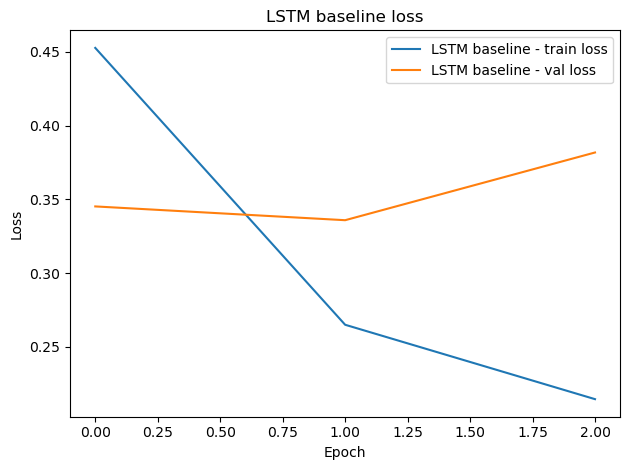

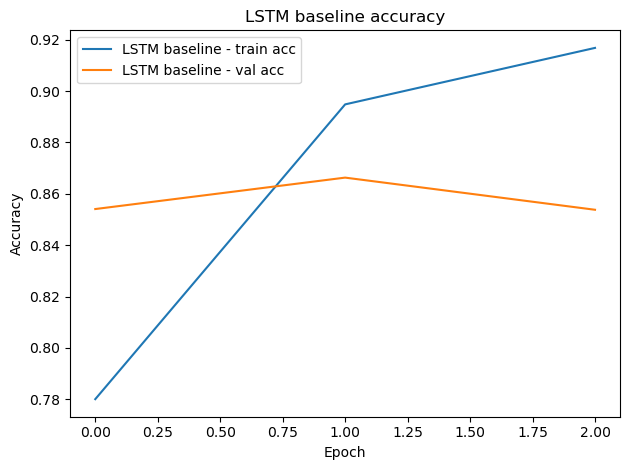

LSTM baseline metrics: {'loss': 0.3358073830604553, 'accuracy': 0.866320013999939, 'perplexity': 1.3990695143675576}

LSTM Classification Report:
               precision    recall  f1-score   support

           0     0.8786    0.8502    0.8641     12500
           1     0.8549    0.8825    0.8684     12500

    accuracy                         0.8663     25000
   macro avg     0.8667    0.8663    0.8663     25000
weighted avg     0.8667    0.8663    0.8663     25000

LSTM Confusion Matrix:
 [[10627  1873]
 [ 1469 11031]]


In [11]:
plot_history({"LSTM baseline": lstm_hist}, title="LSTM baseline loss", filename="lstm_baseline_loss.png")
plot_accuracy({"LSTM baseline": lstm_hist}, title="LSTM baseline accuracy", filename="lstm_baseline_acc.png")

lstm_base_metrics = evaluate_model(lstm_baseline, X_test, y_test)
print("LSTM baseline metrics:", lstm_base_metrics)

lstm_report, lstm_cm = classification_details(lstm_baseline, X_test, y_test)
print("\nLSTM Classification Report:\n", lstm_report)
print("LSTM Confusion Matrix:\n", lstm_cm)


In [12]:
def run_experiment(model_type, maxlen, batch_size, learning_rate, clipnorm=None, epochs=3):
    # Re-pad sequences for the chosen maxlen
    (X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = imdb.load_data(num_words=VOCAB_SIZE)
    X_tr = pad_sequences(X_train_raw, maxlen=maxlen)
    X_te = pad_sequences(X_test_raw,  maxlen=maxlen)

    if model_type == "RNN":
        model = build_rnn_model(VOCAB_SIZE, maxlen, learning_rate=learning_rate, clipnorm=clipnorm)
    else:
        model = build_lstm_model(VOCAB_SIZE, maxlen, learning_rate=learning_rate, clipnorm=clipnorm)

    log_file = f"{model_type.lower()}_m{maxlen}_b{batch_size}_lr{learning_rate}_clip{clipnorm}.csv".replace(".", "p")
    hist = train_model(model, X_tr, y_train_raw, X_te, y_test_raw, epochs=epochs, batch_size=batch_size, log_name=log_file)
    metrics = evaluate_model(model, X_te, y_test_raw)

    return metrics, hist

experiments = [
    # baseline-ish
    {"maxlen": 200, "batch_size": 64, "learning_rate": 1e-3},
    # longer sequence
    {"maxlen": 400, "batch_size": 64, "learning_rate": 1e-3},
    # smaller batch
    {"maxlen": 200, "batch_size": 32, "learning_rate": 1e-3},
    # smaller learning rate
    {"maxlen": 200, "batch_size": 64, "learning_rate": 5e-4},
]

results = []
histories_to_plot = {}

for cfg in experiments:
    for model_type in ["RNN", "LSTM"]:
        metrics, hist = run_experiment(
            model_type=model_type,
            maxlen=cfg["maxlen"],
            batch_size=cfg["batch_size"],
            learning_rate=cfg["learning_rate"],
            clipnorm=None,
            epochs=3  # fewer epochs for faster experimentation
        )
        row = {
            "model": model_type,
            "maxlen": cfg["maxlen"],
            "batch_size": cfg["batch_size"],
            "learning_rate": cfg["learning_rate"],
            "clipnorm": None,
            **metrics
        }
        results.append(row)
        histories_to_plot[f"{model_type} m{cfg['maxlen']} b{cfg['batch_size']} lr{cfg['learning_rate']}"] = hist

df_results = pd.DataFrame(results).sort_values(["model", "accuracy"], ascending=[True, False])
df_results


Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.5697 - loss: 0.6678 - val_accuracy: 0.7806 - val_loss: 0.4737
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.7375 - loss: 0.5172 - val_accuracy: 0.7884 - val_loss: 0.4608
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.7603 - loss: 0.4918 - val_accuracy: 0.7986 - val_loss: 0.4668
Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - accuracy: 0.7850 - loss: 0.4463 - val_accuracy: 0.8573 - val_loss: 0.3398
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 57s 146ms/step - accuracy: 0.8950 - loss: 0.2699 - val_accuracy: 0.8653 - val_loss: 0.3194
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 58s 149ms/step - accuracy: 0.9262 - loss: 0.2025 - val_accuracy: 0.8485 - val_loss: 0.3502
Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 49s 120ms/step - accuracy: 0.6605 - loss: 0.5909 - val_accuracy: 0.8062 - val_loss: 0.4457
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step - accuracy: 0.7388 - loss: 0.5173 - val

,model,maxlen,batch_size,learning_rate,clipnorm,loss,accuracy,perplexity
7,LSTM,200,64,0.0005,None,0.309705,0.87392,1.363023
1,LSTM,200,64,0.0010,None,0.319442,0.86528,1.376360
3,LSTM,400,64,0.0010,None,0.327580,0.86236,1.387606
5,LSTM,200,32,0.0010,None,0.329222,0.86108,1.389886
6,RNN,200,64,0.0005,None,0.364658,0.84940,1.440021
2,RNN,400,64,0.0010,None,0.445727,0.80624,1.561625
0,RNN,200,64,0.0010,None,0.460798,0.78844,1.585339
4,RNN,200,32,0.0010,None,0.493981,0.76400,1.638827


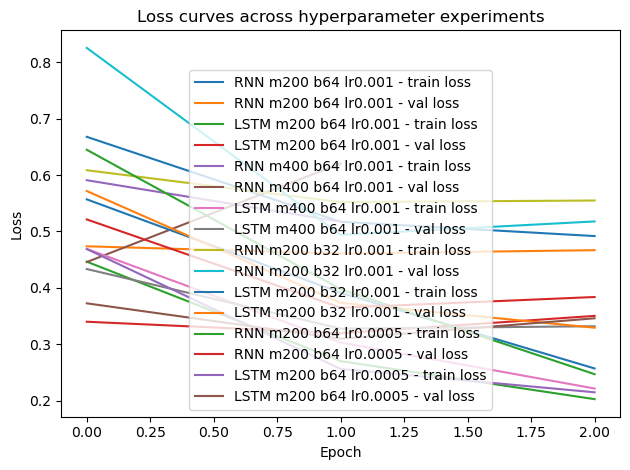

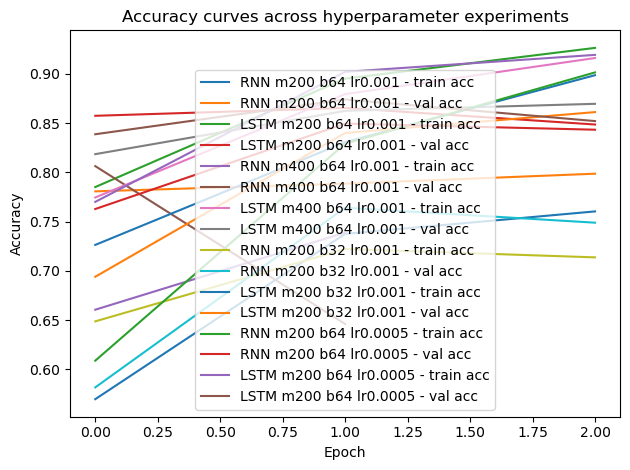

Saved results table to logs/hyperparam_results.csv


In [13]:
plot_history(histories_to_plot, title="Loss curves across hyperparameter experiments", filename="hyperparam_loss_comparison.png")
plot_accuracy(histories_to_plot, title="Accuracy curves across hyperparameter experiments", filename="hyperparam_acc_comparison.png")

df_results.to_csv(os.path.join("logs", "hyperparam_results.csv"), index=False)
print("Saved results table to logs/hyperparam_results.csv")


In [14]:
clipnorm_value = 1.0

# Pick ONE configuration to demonstrate clipping clearly (use your best LSTM config if you want)
cfg = {"maxlen": 200, "batch_size": 64, "learning_rate": 1e-3}

# Re-pad once
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = imdb.load_data(num_words=VOCAB_SIZE)
X_tr = pad_sequences(X_train_raw, maxlen=cfg["maxlen"])
X_te = pad_sequences(X_test_raw,  maxlen=cfg["maxlen"])

# RNN without clipping
rnn_no_clip = build_rnn_model(VOCAB_SIZE, cfg["maxlen"], learning_rate=cfg["learning_rate"], clipnorm=None)
hist_rnn_no = train_model(rnn_no_clip, X_tr, y_train_raw, X_te, y_test_raw, epochs=3, batch_size=cfg["batch_size"], log_name="rnn_no_clip.csv")
m_rnn_no = evaluate_model(rnn_no_clip, X_te, y_test_raw)

# RNN with clipping
rnn_clip = build_rnn_model(VOCAB_SIZE, cfg["maxlen"], learning_rate=cfg["learning_rate"], clipnorm=clipnorm_value)
hist_rnn_clip = train_model(rnn_clip, X_tr, y_train_raw, X_te, y_test_raw, epochs=3, batch_size=cfg["batch_size"], log_name="rnn_clip.csv")
m_rnn_clip = evaluate_model(rnn_clip, X_te, y_test_raw)

# LSTM without clipping
lstm_no_clip = build_lstm_model(VOCAB_SIZE, cfg["maxlen"], learning_rate=cfg["learning_rate"], clipnorm=None)
hist_lstm_no = train_model(lstm_no_clip, X_tr, y_train_raw, X_te, y_test_raw, epochs=3, batch_size=cfg["batch_size"], log_name="lstm_no_clip.csv")
m_lstm_no = evaluate_model(lstm_no_clip, X_te, y_test_raw)

# LSTM with clipping
lstm_clip = build_lstm_model(VOCAB_SIZE, cfg["maxlen"], learning_rate=cfg["learning_rate"], clipnorm=clipnorm_value)
hist_lstm_clip = train_model(lstm_clip, X_tr, y_train_raw, X_te, y_test_raw, epochs=3, batch_size=cfg["batch_size"], log_name="lstm_clip.csv")
m_lstm_clip = evaluate_model(lstm_clip, X_te, y_test_raw)

clip_compare = pd.DataFrame([
    {"model":"RNN", "clipnorm":None, **m_rnn_no},
    {"model":"RNN", "clipnorm":clipnorm_value, **m_rnn_clip},
    {"model":"LSTM", "clipnorm":None, **m_lstm_no},
    {"model":"LSTM", "clipnorm":clipnorm_value, **m_lstm_clip},
])
clip_compare


Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.6032 - loss: 0.6555 - val_accuracy: 0.6866 - val_loss: 0.5862
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8190 - loss: 0.4108 - val_accuracy: 0.7993 - val_loss: 0.4467
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.9032 - loss: 0.2412 - val_accuracy: 0.7891 - val_loss: 0.5232
Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 76ms/step - accuracy: 0.6773 - loss: 0.5610 - val_accuracy: 0.7895 - val_loss: 0.5005
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.8571 - loss: 0.3477 - val_accuracy: 0.8160 - val_loss: 0.4095
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.8799 - loss: 0.3031 - val_accuracy: 0.8394 - val_loss: 0.3986
Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 199ms/step - accuracy: 0.7818 - loss: 0.4501 - val_accuracy: 0.8606 - val_loss: 0.3382
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 75s 191ms/step - accuracy: 0.8978 - loss: 0.2643 - val_ac

,model,clipnorm,loss,accuracy,perplexity
0,RNN,NaN,0.446702,0.79932,1.563149
1,RNN,1.0,0.398564,0.83940,1.489683
2,LSTM,NaN,0.327084,0.87160,1.386918
3,LSTM,1.0,0.337461,0.86112,1.401385


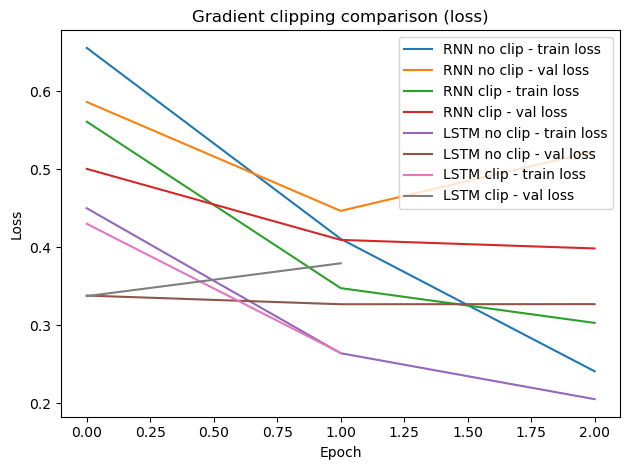

In [15]:
plot_history(
    {
        "RNN no clip": hist_rnn_no,
        "RNN clip": hist_rnn_clip,
        "LSTM no clip": hist_lstm_no,
        "LSTM clip": hist_lstm_clip
    },
    title="Gradient clipping comparison (loss)",
    filename="gradient_clipping_loss.png"
)
